In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:00<00:00, 20190.25it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

# dataset_12lead = WindowDataset(data_12lead, labelmap, device=device)

In [7]:
dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)


In [8]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

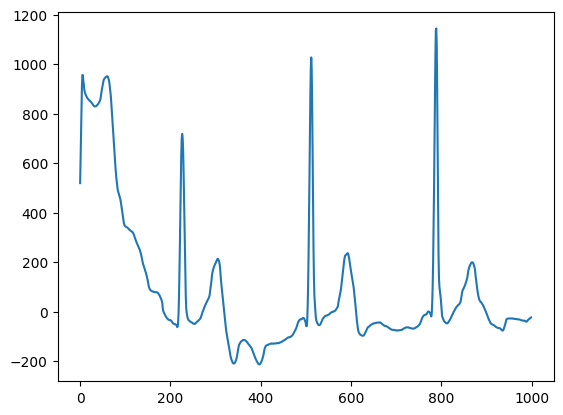

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[3][0])

In [10]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

In [11]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

# history = train_kfold_model(dataset_1lead, trainparams, test=)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [12]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 250

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/250 AVG Training Loss:0.02496 AVG Test Loss:0.02362 AVG Training Acc 52.22 % AVG Test Acc 54.36 %
Epoch:20/250 AVG Training Loss:0.02288 AVG Test Loss:0.02199 AVG Training Acc 59.80 % AVG Test Acc 62.32 %
Epoch:30/250 AVG Training Loss:0.02212 AVG Test Loss:0.02134 AVG Training Acc 61.57 % AVG Test Acc 64.05 %
Epoch:40/250 AVG Training Loss:0.02162 AVG Test Loss:0.02036 AVG Training Acc 62.78 % AVG Test Acc 64.82 %
Epoch:50/250 AVG Training Loss:0.02102 AVG Test Loss:0.02024 AVG Training Acc 64.74 % AVG Test Acc 68.21 %
Epoch:60/250 AVG Training Loss:0.02049 AVG Test Loss:0.01945 AVG Training Acc 65.68 % AVG Test Acc 67.17 %
Epoch:70/250 AVG Training Loss:0.02026 AVG Test Loss:0.01977 AVG Training Acc 65.82 % AVG Test Acc 69.54 %
Epoch:80/250 AVG Training Loss:0.02016 AVG Test Loss:0.01915 AVG Training Acc 66.96 % AVG Test Acc 69.50 %
Epoch:90/250 AVG Training Loss:0.01990 AVG Test Loss:0.01907 AVG Training Acc 66.83 % AVG Test Acc 69.41 %
Epoch:100/250 AVG Training Loss:0.019

Fold 1
Epoch:10/100 AVG Training Loss:0.00597 AVG Test Loss:0.00534 AVG Training Acc 71.30 % AVG Test Acc 67.73 %
Epoch:20/100 AVG Training Loss:0.00504 AVG Test Loss:0.00522 AVG Training Acc 77.95 % AVG Test Acc 68.83 %
Epoch:30/100 AVG Training Loss:0.00417 AVG Test Loss:0.00566 AVG Training Acc 84.59 % AVG Test Acc 69.23 %
Epoch:40/100 AVG Training Loss:0.00368 AVG Test Loss:0.00587 AVG Training Acc 88.22 % AVG Test Acc 70.10 %
Epoch:50/100 AVG Training Loss:0.00308 AVG Test Loss:0.00637 AVG Training Acc 92.75 % AVG Test Acc 67.19 %
Epoch:60/100 AVG Training Loss:0.00278 AVG Test Loss:0.00688 AVG Training Acc 92.45 % AVG Test Acc 68.60 %
Epoch:70/100 AVG Training Loss:0.00256 AVG Test Loss:0.00710 AVG Training Acc 93.96 % AVG Test Acc 68.20 %
Epoch:80/100 AVG Training Loss:0.00223 AVG Test Loss:0.00772 AVG Training Acc 96.68 % AVG Test Acc 67.99 %
Epoch:90/100 AVG Training Loss:0.00235 AVG Test Loss:0.00801 AVG Training Acc 94.86 % AVG Test Acc 67.43 %
Epoch:100/100 AVG Training Los

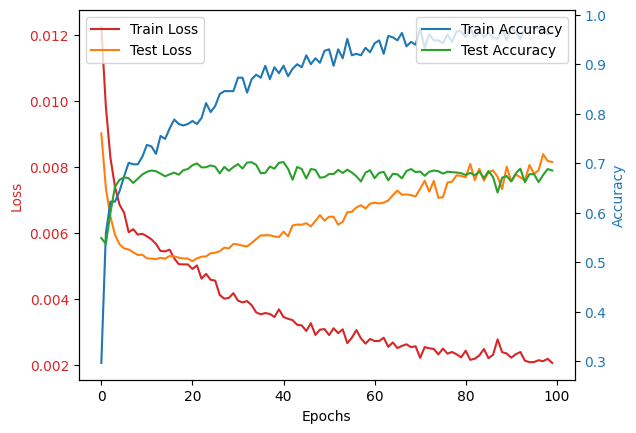

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.001954056822932101, average accuracy 98.58324536817966
Test: Average loss 0.008017896228298974, average accuracy 71.13392124972897


In [13]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9

history = train_kfold_transfer_model(dataset_12lead, buffer, trainparams, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.01019 AVG Test Loss:0.00893 AVG Training Acc 31.72 % AVG Test Acc 39.64 %
Epoch:20/200 AVG Training Loss:0.00996 AVG Test Loss:0.00879 AVG Training Acc 37.46 % AVG Test Acc 43.05 %
Epoch:30/200 AVG Training Loss:0.00967 AVG Test Loss:0.00844 AVG Training Acc 47.43 % AVG Test Acc 54.03 %
Epoch:40/200 AVG Training Loss:0.00817 AVG Test Loss:0.00734 AVG Training Acc 61.03 % AVG Test Acc 57.75 %
Epoch:50/200 AVG Training Loss:0.00642 AVG Test Loss:0.00720 AVG Training Acc 69.49 % AVG Test Acc 59.52 %
Epoch:60/200 AVG Training Loss:0.00594 AVG Test Loss:0.00704 AVG Training Acc 74.32 % AVG Test Acc 62.64 %
Epoch:70/200 AVG Training Loss:0.00509 AVG Test Loss:0.00685 AVG Training Acc 77.95 % AVG Test Acc 64.04 %
Epoch:80/200 AVG Training Loss:0.00470 AVG Test Loss:0.00725 AVG Training Acc 78.55 % AVG Test Acc 64.71 %
Epoch:90/200 AVG Training Loss:0.00382 AVG Test Loss:0.00735 AVG Training Acc 81.27 % AVG Test Acc 65.42 %
Epoch:100/200 AVG Training Los

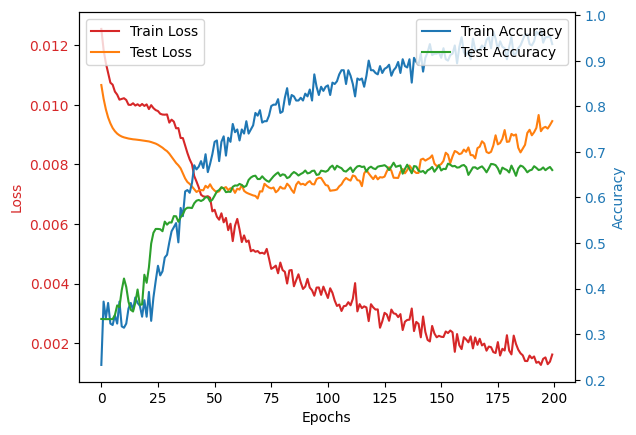

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0016897009090562714, average accuracy 95.6300731627416
Test: Average loss 0.009186447995013246, average accuracy 66.27142152722077


In [15]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9

history = train_control_12lead_model(dataset_12lead, trainparams, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)